<a href="https://colab.research.google.com/github/MicroprocessorX069/Handwriting-comparison/blob/master/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import math

In [0]:
#Dataset=pd.read_csv('Data_equalSamples (1).csv')
Dataset=pd.read_csv('Data.csv')

In [0]:
def createDataset(df,train_percent, validation_percent):
  df=df.loc[:,'Af1':'target']
  length=df.shape[0]
  
  trainEnd=int(length*train_percent)
  
  validationEnd=trainEnd+int(length*validation_percent)
  
  trainData=df.iloc[0:trainEnd]
  trainResult=trainData.loc[:,'target']
  trainData=trainData.loc[:,'Af1':'Bf9']
  trainResult=trainResult.reset_index(drop=True)
  trainData=trainData.reset_index(drop=True)
  
  validationData=df.iloc[trainEnd:validationEnd]
  validationResult=validationData.loc[:,'target']
  validationData=validationData.loc[:,'Af1':'Bf9']
  validationResult=validationResult.reset_index(drop=True)
  validationData=validationData.reset_index(drop=True)
  
  testData=df.iloc[validationEnd:length]
  testResult=testData.loc[:,'target']
  testData=testData.loc[:,'Af1':'Bf9']
  testResult=testResult.reset_index(drop=True)
  testData=testData.reset_index(drop=True)
  
  return trainData, trainResult, validationData, validationResult, testData, testResult
  
def clusterIndices(no_clusters, labels_array): #numpy 
  for cluster_no in range(no_clusters):
    
   return np.where(labels_array == no_clusters)[0]

def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
  # To calculate BigSigma as
  #BigSigma 41 x 41
  #Matrix of variances between input features, to calculate PhiMatrix
    '''
                          x(1)      x(2)      x(3) .  .  .     x(41)
    BigSigma =   x(1)  Var(1,1)      0         0                 0

                 x(2)       0      Var(2,2)    0                 0

                 x(3)       0       0        Var(3,3)            0
                  .
                  .
                  .
                 x(41)                                      Var(41,41)
      '''        
    
    #Initializing BigSigma matrix as zeros since we just have to populate the diagonal elements
    
    BigSigma    = np.zeros((len(Data),len(Data))) #shape = 41,41
    DataT       = np.transpose(Data) #len(DataT)=69k 
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01)) #math ceil return smallest integer less than X, basically converting to nearest bigger int #Len of training data set = 80% of 69k ~ 67k 
    varVect     = []
    
    # Calculating the variance for each input feature, based on training data. np.var return variance of an array
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct)) #Varianance of Data[i,;] i.e. input feature i
    
    #Populating BigSigma Matrix
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j] ## All other indices other than j,j (i.e. where i != j) would be zero since the covariance between two input features is no required.
    if IsSynthetic == True:         # Use of isSynthetic not known yet
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    #Converts the matrices' (x-Mu), BigSigmaInverse, (x-Mu) product to scalar
    
    #R is (x-Mu); Shape : 1 x 41
    R = np.subtract(DataRow,MuRow)
    #np.transpose(R) is Transpose of (x-Mu); Shape :  41 x 1
    # Shape of BigSigInv is 41 x 41
    # Therefore Shape of T i.e. (R x BigSigmaInverse x Inv(R)): (41) x 41) . (41 x 1)
    #                                                          : 41 x 1 
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T) #(R . T)
    # Therefore Shape of T i.e. (R x BigSigmaInverse x Inv(R)): (1 x 41). (41) x 41) . (41 x 1)
    #                                                          : 1 x 1 # HenceScalaar
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):  
  #Calculation of Phi(x)
  #Vector Phi(x) = (-0.5 . (x-Mu) . BigSigmaInverse . (x-Mu))
   #              e
    # math.exp is exponential function e^(x) where x is the argument of the function
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    #Phi Matrix Shape:  No. of basis fns x Dataset_height i.e. 10 x 67k
    # 10 Basis function matrix applied on 41 input feautres
    '''
    #Phi(x(1)(1/10)) Means Basis function of 1/10 th part of input feature 1 (We divided the input features with kmeans below into 10 clusters)
    
    Vector Phi(x) = (-0.5 . (x-Mu) . BigSigmaInverse . (x-Mu))
                   e
                   
                   
                        Phi1                   Phi2                     Phi3                    .  .  .     Phi10    # no of basis functions i.e. 10
  PhiMatrix=   x(1)   Phi(x(1)(1/10))      Phi(x(1)(2/10))         Phi(x(1)(3/10))     .  .  .        Phi(x(1)(10/10))
  
               x(2)   Phi(x(2)(1/10))      Phi(x(2)(2/10))         Phi(x(2)(3/10))     .  .  .        Phi(x(2)(10/10))
    
               x(3)   Phi(x(3)(1/10))      Phi(x(3)(2/10))         Phi(x(3)(3/10))     .  .  .        Phi(x(3)(10/10))
                .
                .
                .
              x(67k)  Phi(x(67k)(1/10))    Phi(x(67k)(2/10))       Phi(x(67k)(3/10))     .  .  .      Phi(x(67k)(1/10))
    '''        
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    
    # Calculating inverse of BigSigma matrix for the formula of phi
    BigSigInv = np.linalg.pinv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            #Calculating Phi of each x1
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

In [91]:
validation_percent=0
train_percent=0.7
m=8
IsSynthetic=False
trainData, trainResult, validationData, validationResult, testData, testResult = createDataset(Dataset,train_percent, validation_percent)

trainData=np.array(trainData)
trainResult=np.array(trainResult)
testData=np.array(testData)
testResult=np.array(testResult)

from sklearn.cluster import KMeans

trainTranspose=np.transpose(trainData)
kmeans=KMeans(m,random_state=0).fit(trainData)
means=np.array(kmeans.cluster_centers_)
variance_mat     = GenerateBigSigma(trainTranspose, means,100 ,IsSynthetic) # generating variance for each input feature
train_phi = GetPhiMatrix(trainTranspose, means, variance_mat, 100)
print(train_phi.shape)

testTranspose=np.transpose(testData)
kmeans=KMeans(m,random_state=0).fit(testData)
means=np.array(kmeans.cluster_centers_)
#ClusterIndicesNumpy(7, kmeans.labels_)
variance_mat     = GenerateBigSigma(testTranspose, means,100 ,IsSynthetic) # generating variance for each input feature
test_phi = GetPhiMatrix(testTranspose, means, variance_mat, 100)
print(test_phi.shape)


(205676, 8)
(88147, 8)


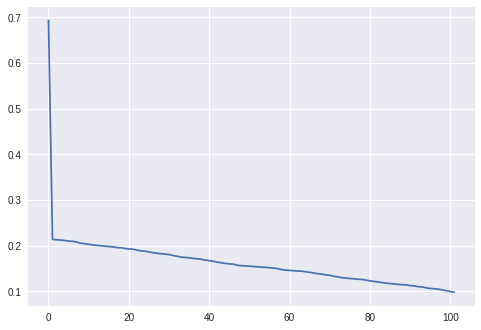

In [120]:
import matplotlib.pyplot as plt
plt.plot(grad_descent(train_phi,trainResult,test_phi,testResult,batch_size=2000,learning_rate=0.1))
plt.show()

In [0]:
logisticReg(train_phi,trainResult,test_phi,testResult,0.2,5)

In [0]:
import math


def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def logisticReg(trainData,trainResult,testData,testResult,learning_rate=0.2,no_epochs=5):
  W=np.zeros(trainData.shape[1])
  j=-1
  for epoch in range(0,no_epochs):
    #print("epoch no:", epoch)
    j=-1
    for input in trainData:
      output=W[0]
      j=j+1

      for i in range(1,len(W)):
        output=output+W[i]*input[i-1]
      target=trainResult[j]
      output=sigmoid(output)
      for i in range(0,len(W)):  
        if(i==0):
          weight_change=learning_rate*(target-output)*output*(1-output)
          W[i]=W[i]+weight_change
        else:
          weight_change=learning_rate*(target-output)*output*(1-output)*input[i-1]
          W[i]=W[i]+weight_change
      print("updated weight times:",epoch, j)
  correct=0
  j=-1
  for input in testData:
    output=W[0]
    j=j+1
    for i in range(1,len(W)):
      output=output+W[i]*input[i-1]
    target=testResult[j]
    output=round(sigmoid(output),0)
    if(target==output):
      correct=correct+1
  print((correct*100)/j)
  
def getOutput(input_data, weights):
  predicted_result=[]
  for input in input_data:
      output=0
      for i in range(1,len(W)):
        output=output+weights[i]*input[i-1]
      output=sigmoid(output)
      predicted_result.append(output)
  return(np.array(predicted_result))

def updateWeights(input_data,target_result,predicted_result,prev_weights,learning_rate):
  subtract=np.subtract(predicted_result,target_result)
  weight_change=np.dot(subtract,input_data)
  weight_change/=(input_data.shape[1])
  weight_change*=learning_rate
  new_weights=np.subtract(prev_weights,weight_change)
  return new_weights

def loss(target_result,predicted_result):
  loss=-target_result*np.log(predicted_result)-(1-target_result)*np.log(1-predicted_result)
  loss=loss.sum()/target_result.shape[0]
  return loss
  
     
   



In [0]:

def grad_descent(train_phi,trainResult,validation_phi,validationResult,batch_size=5000,learning_rate=0.2):
  W=np.zeros(train_phi.shape[1])
  i=0
  loss_arr=[]
  while i+batch_size <= train_phi.shape[0]:
    input_data=train_phi[i:i+batch_size]
    target_result=trainResult[i:i+batch_size]
    i=i+batch_size
    new_lr=learning_rate-(1/i)
    if(new_lr<=0):
      new_lr=learning_rate
    predicted_result=getOutput(input_data,W)
    validation_predictedResult=getOutput(validation_phi,W)
    W=updateWeights(input_data,target_result,predicted_result,W,learning_rate)
    loss_arr.append(loss(validationResult,validation_predictedResult))
  return(loss_arr)
